# Basic text classification

In [47]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import losses
import numpy as np

import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)
print(tfds.__version__)

2.8.2
4.0.1


In [3]:
filename = 'comment-spam.csv'

data_file = tf.keras.utils.get_file(fname=filename, 
  origin='https://storage.googleapis.com/laurencemoroney-blog.appspot.com/lmblog_comments.csv', 
  extract=False)

dataset_dir = os.path.join(os.path.dirname(data_file), filename)
dataset_dir

245760/235543 [===============================] - 0s 0us/step


'/root/.keras/datasets/comment-spam.csv'

In [4]:
# data = DataLoader.from_csv(
#     filename=data_file,
#     text_column='commenttext',
#     label_column='spam',
#     model_spec=spec,
#     delimiter=',',
#     shuffle=True,
#     is_training=True)

# train_data, test_data = data.split(0.9)

In [5]:
df_dados = pd.read_csv(dataset_dir)
print("Shape", df_dados.shape)
df_dados.head()

Shape (1000, 2)


,commenttext,spam
0,still need pick one,False
1,… i similar problem careful version cuda ver...,True
2,visual range five seconds,False
3,family come trusted tonight,False
4,cute,False


In [6]:
print(df_dados.dtypes)

commenttext    object
spam             bool
dtype: object


In [8]:
dict_target = {True:1, False:0}
df_dados['spam'] = df_dados['spam'].map(dict_target)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_dados['commenttext'], df_dados['spam'], test_size=0.2, random_state=42)

In [11]:
X_train[0], y_train[0]

('still need pick one ', 0)

In [19]:
# Encontrar o tamanho médio das frases
X_train.head().str.split().apply(len).mean()

6.2

In [22]:
max_features = 1000
sequence_length = 10

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [23]:
vectorize_layer.adapt(X_train)

In [24]:
vectorize_layer(X_train[0]), y_train[0]

(<tf.Tensor: shape=(10,), dtype=int64, numpy=array([261,  88,   1,  35,   0,   0,   0,   0,   0,   0])>,
 0)

In [56]:
X_train_vector = vectorize_layer(X_train)
X_test_vector = vectorize_layer(X_test)

In [57]:
X_train_vector.numpy()[0]

array([64,  1,  0,  0,  0,  0,  0,  0,  0,  0])

## Input and Output shape

In [58]:
# Input and output Shape 
print("Input:", X_train_vector.numpy()[0].shape)
print("Output:", y_train[0].shape)

Input: (10,)
Output: (1,)


In [59]:
#Input shape
X_train_vector = np.expand_dims(X_train_vector.numpy(), axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_test_vector = np.expand_dims(X_test_vector.numpy(), axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [61]:
# Input and output Shape 
print("Input:", X_train_vector[0].shape)
print("Output:", y_train[0].shape)

Input: (10, 1)
Output: (1, 1)


### Create the model

It's time to create your neural network:

In [71]:
from gc import callbacks
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 16)          16016     
                                                                 
 dropout_10 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_5   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 16,033
Trainable params: 16,033
Non-trainable params: 0
__________________________________________________

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [72]:
# Set random seed
tf.random.set_seed(42)

epochs = 30

# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Callback to save the best weights during training process
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)


history = model.fit(X_train_vector,
                    y_train,
                    validation_data=(X_test_vector, y_test),
                    epochs=epochs,
                    verbose=1,
                    callbacks=[early_stop, model_checkpoint_callback])


# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/30
25/25 [==============================] - 1s 9ms/step - loss: 0.6907 - binary_accuracy: 0.5387 - val_loss: 0.6745 - val_binary_accuracy: 0.7450
Epoch 2/30
25/25 [==============================] - 0s 5ms/step - loss: 0.6569 - binary_accuracy: 0.7725 - val_loss: 0.6425 - val_binary_accuracy: 0.7650
Epoch 3/30
25/25 [==============================] - 0s 4ms/step - loss: 0.6215 - binary_accuracy: 0.7912 - val_loss: 0.6071 - val_binary_accuracy: 0.8000
Epoch 4/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5813 - binary_accuracy: 0.8200 - val_loss: 0.5688 - val_binary_accuracy: 0.8050
Epoch 5/30
25/25 [==============================] - 0s 4ms/step - loss: 0.5379 - binary_accuracy: 0.8587 - val_loss: 0.5292 - val_binary_accuracy: 0.8150
Epoch 6/30
25/25 [==============================] - 0s 4ms/step - loss: 0.4954 - binary_accuracy: 0.8700 - val_loss: 0.4901 - val_binary_accuracy: 0.8400
Epoch 7/30
25/25 [==============================] - 0s 5ms/step - loss: 0.45

### Evaluate the model

In [73]:
loss, accuracy = model.evaluate(X_test_vector, y_test)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

7/7 [==============================] - 0s 2ms/step - loss: 0.1881 - binary_accuracy: 0.9350
Loss:  0.1880764216184616
Accuracy:  0.9350000023841858


In [74]:
# Plot the validation and training data separately
def plot_loss_curves(history, metric="mae"):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history[metric]
  val_accuracy = history.history[f'val_{metric}']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(15, 5))
  # Plot loss
  plt.subplot(1, 2, 1)
  plt.title('Loss')
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.title(metric)
  plt.plot(epochs, accuracy, label=f'training_{metric}')
  plt.plot(epochs, val_accuracy, label=f'val_{metric}')
  plt.xlabel('Epochs')
  plt.legend();

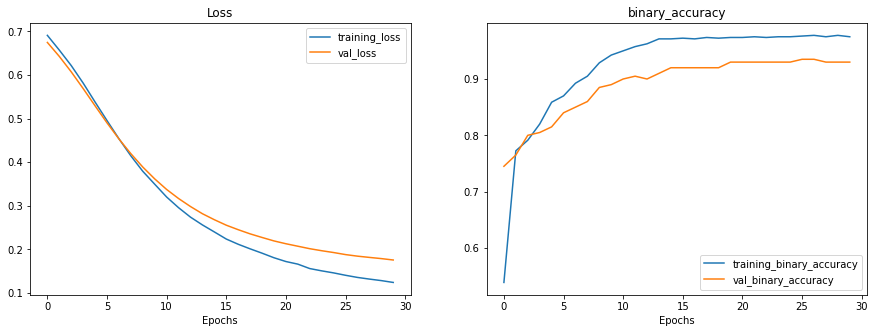

In [75]:
plot_loss_curves(history, metric="binary_accuracy")

## Save the model

In [76]:
# Save TF Hub Sentence Encoder model to h5 format
filename = "model_NLP_spam.h5"
model.save(filename)

In [77]:
!zip -r model.zip $filename

updating: model_NLP_spam.h5 (deflated 40%)


In [78]:
!ls -hl

total 352K
-rw-r--r-- 1 root root 215K Jun 20 11:55 model_NLP_spam.h5
-rw-r--r-- 1 root root 129K Jun 20 11:55 model.zip
drwxr-xr-x 1 root root 4.0K Jun 15 13:42 sample_data


In [79]:
try:
  from google.colab import files
  files.download(filename)
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>